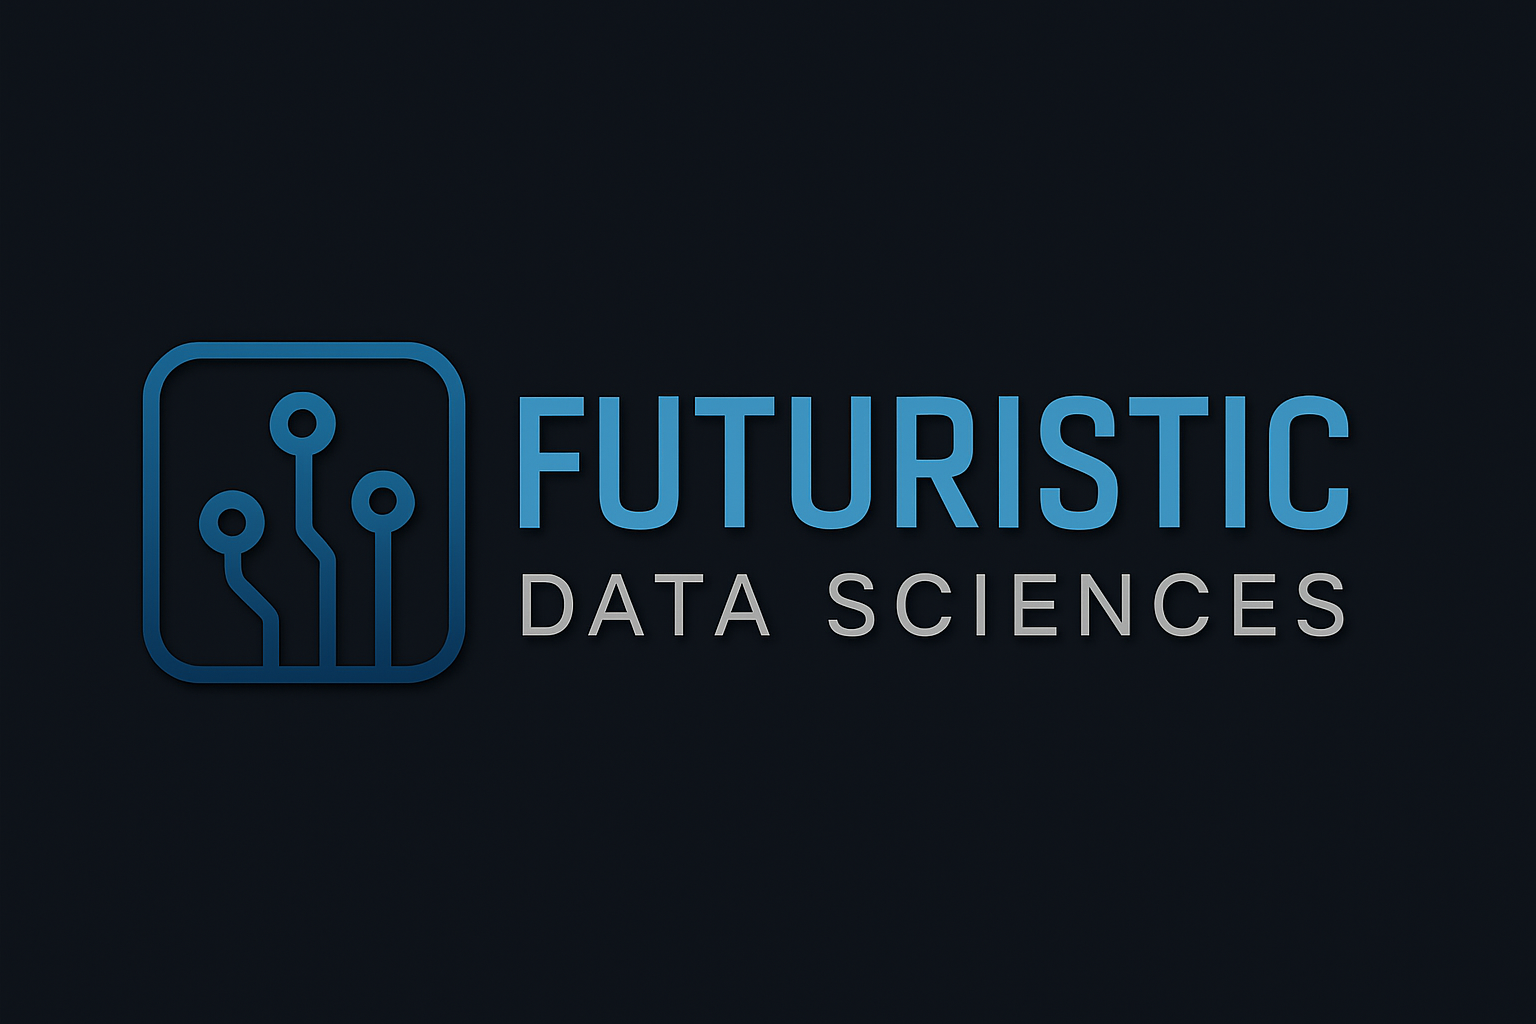

In [47]:
from IPython.display import Image
Image("imagen colab.png")

In [48]:
# 🚀 Telecom X - Parte 2: Predicción de Churn
# Autor: Hideky Lizardo | github.com/lizardohideky
# Datos: https://github.com/alura-cursos/challenge2-data-science-LATAM

# --- 🔽 Instalación de librerías ---
!pip install -q seaborn scikit-learn matplotlib joblib

# --- 🔽 Importación de librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import joblib
import json
import requests

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- 🔽 Carga de datos desde GitHub (JSON) ---
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print("✅ Datos cargados correctamente desde TelecomX_Data.json")
except Exception as e:
    print("❌ Error al cargar el archivo JSON:", e)
    raise

# Convertir a DataFrame
df = pd.json_normalize(data)
print(f"✅ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
df.head()

✅ Datos cargados correctamente desde TelecomX_Data.json
✅ Dataset cargado: 7267 filas, 21 columnas


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [49]:
# --- 🧹 Limpieza y Preparación (Parte 1 mejorada) ---
print("🧹 Iniciando limpieza de datos...")

# Renombrar columnas a formato limpio
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('.', '_')

# Manejar valores nulos
df = df.dropna()

# Convertir campos numéricos
numeric_cols = ['customer_tenure', 'account_charges_monthly', 'account_charges_total']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=numeric_cols).reset_index(drop=True)

# Ensure 'churn' is string type before stripping and mapping
df['churn'] = df['churn'].astype(str).str.strip().map({'Yes': 1, 'No': 0})

# Eliminar customerID si existe
if 'customerid' in df.columns:
    df = df.drop(columns=['customerid'])

print(f"✅ Limpieza completada: {df.shape[0]} filas restantes")

🧹 Iniciando limpieza de datos...
✅ Limpieza completada: 7256 filas restantes



📌 Distribución del Churn:
churn
0.0    0.734215
1.0    0.265785
Name: proportion, dtype: float64


/tmp/ipython-input-3361694581.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='churn', palette='coolwarm')


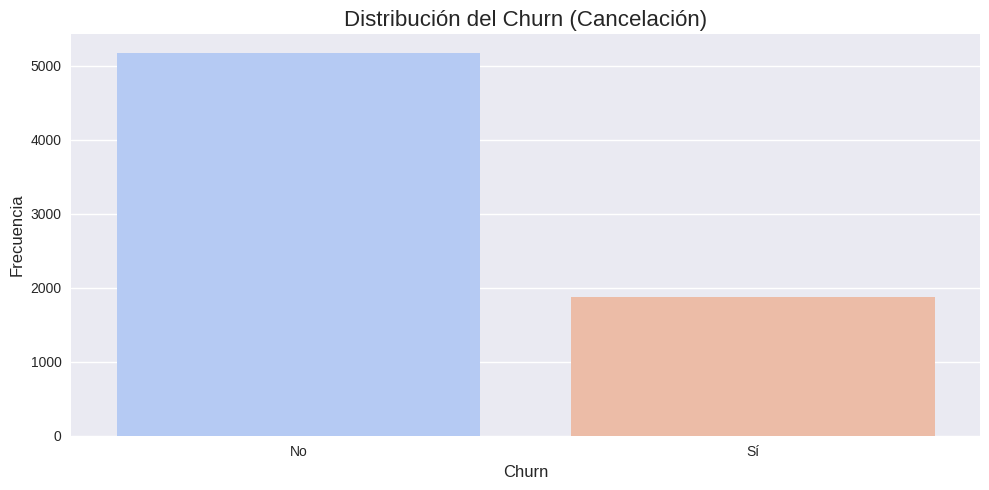

In [59]:
# --- 📊 Análisis Exploratorio (EDA) ---
print("\n📌 Distribución del Churn:")
print(df['churn'].value_counts(normalize=True))

# Visualización: Distribución del Churn
plt.figure(figsize=(10, 5)) # Increased width
sns.countplot(data=df, x='churn', palette='coolwarm')
plt.title('Distribución del Churn (Cancelación)', fontsize=16)
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.tight_layout()
plt.show()



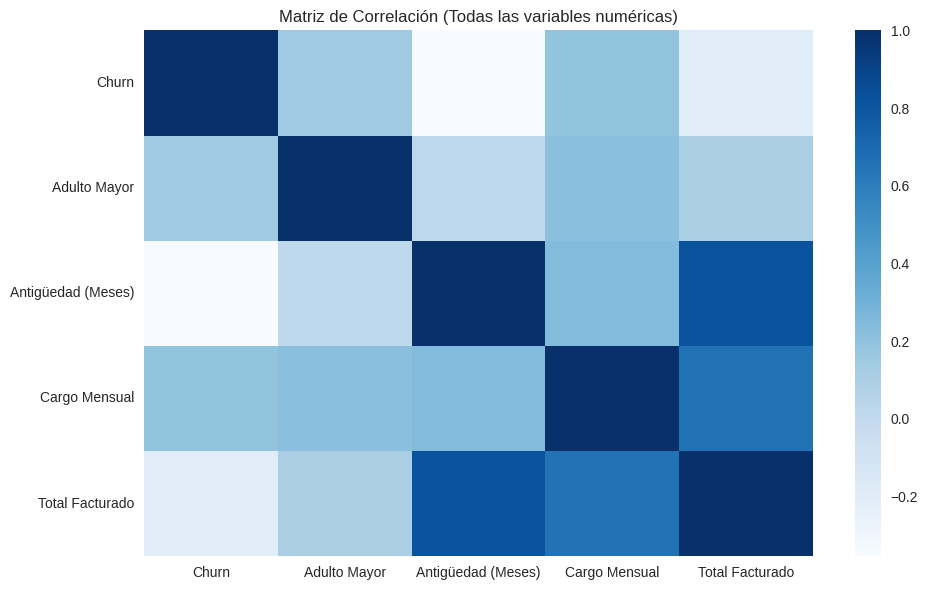

In [60]:
# Matriz de correlación
plt.figure(figsize=(10, 6))
correlacion = df.select_dtypes(include=[np.number]).corr()

# Mapping English column names to Spanish for the heatmap
column_translation = {
    'churn': 'Churn',
    'customer_seniorcitizen': 'Adulto Mayor',
    'customer_tenure': 'Antigüedad (Meses)',
    'account_charges_monthly': 'Cargo Mensual',
    'account_charges_total': 'Total Facturado'
}

# Rename columns and index for plotting
correlacion_spanish = correlacion.rename(columns=column_translation, index=column_translation)

sns.heatmap(correlacion_spanish, annot=False, cmap='Blues', fmt='.2f')
plt.title('Matriz de Correlación (Todas las variables numéricas)')
plt.tight_layout()
plt.show()

In [36]:
# --- 🧱 Preprocesamiento para Modelado ---
print("\n🧱 Iniciando preprocesamiento para modelado...")

# Asegurarse de que 'churn' no tenga NaN antes de separar
df = df.dropna(subset=['churn']).reset_index(drop=True)

# Separar X e y
X = df.drop('churn', axis=1)
y = df['churn']

# Identificar tipos de variables
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

print("✅ Datos separados en conjuntos de entrenamiento y prueba.")


🧱 Iniciando preprocesamiento para modelado...
✅ Datos separados en conjuntos de entrenamiento y prueba.


In [37]:
# --- 🧠 Entrenamiento de Modelos ---
print("🚀 Entrenando modelos...")

# 1. Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# 2. Regresión Logística
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 3. KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Entrenar
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)
print("✅ Modelos entrenados")

🚀 Entrenando modelos...
✅ Modelos entrenados



📊 Resultados - Random Forest:
  Exactitud:  0.787
  Precisión:  0.637
  Recall:     0.465
  F1-Score:   0.538
  AUC-ROC:    0.685


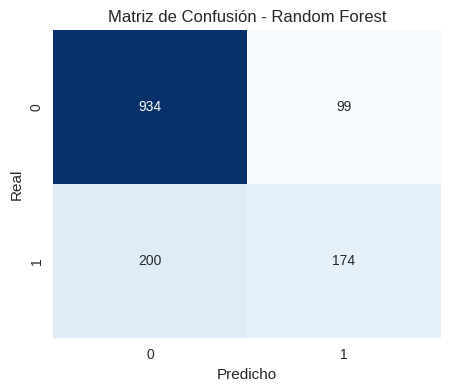


📊 Resultados - Regresión Logística:
  Exactitud:  0.800
  Precisión:  0.651
  Recall:     0.529
  F1-Score:   0.584
  AUC-ROC:    0.713


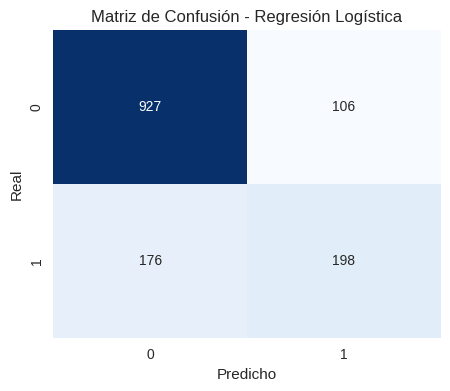


📊 Resultados - KNN:
  Exactitud:  0.758
  Precisión:  0.548
  Recall:     0.500
  F1-Score:   0.523
  AUC-ROC:    0.675


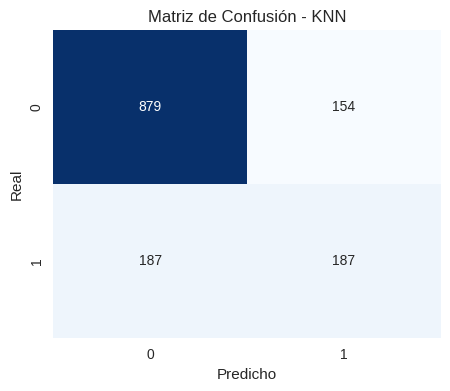

In [38]:
# --- 📊 Evaluación de Modelos ---
def evaluar_modelo(model, X_test, y_test, nombre):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"\n📊 Resultados - {nombre}:")
    print(f"  Exactitud:  {acc:.3f}")
    print(f"  Precisión:  {prec:.3f}")
    print(f"  Recall:     {rec:.3f}")
    print(f"  F1-Score:   {f1:.3f}")
    print(f"  AUC-ROC:    {auc:.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()

    return {'modelo': nombre, 'f1': f1, 'auc': auc}

resultados = []
resultados.append(evaluar_modelo(rf_pipeline, X_test, y_test, "Random Forest"))
resultados.append(evaluar_modelo(lr_pipeline, X_test, y_test, "Regresión Logística"))
resultados.append(evaluar_modelo(knn_pipeline, X_test, y_test, "KNN"))

In [26]:
# --- 📈 Comparación de Modelos ---
resultados_df = pd.DataFrame(resultados)
print("\n🏆 Comparación Final de Modelos:")
print(resultados_df[['modelo', 'f1', 'auc']].round(3))

mejor_modelo = resultados_df.loc[resultados_df['f1'].idxmax()]
print(f"\n🎯 Mejor modelo (por F1): {mejor_modelo['modelo']} con F1 = {mejor_modelo['f1']:.3f}")

# Guardar modelo ganador
joblib.dump(rf_pipeline, 'modelo_churn_rf.pkl')
print("\n✅ Modelo guardado como 'modelo_churn_rf.pkl'")


🏆 Comparación Final de Modelos:
                modelo     f1    auc
0        Random Forest  0.538  0.685
1  Regresión Logística  0.584  0.713
2                  KNN  0.523  0.675

🎯 Mejor modelo (por F1): Regresión Logística con F1 = 0.584

✅ Modelo guardado como 'modelo_churn_rf.pkl'



📊 Importancia de Variables (Random Forest):


/tmp/ipython-input-3250709867.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance, y=top_features_spanish, palette='viridis')


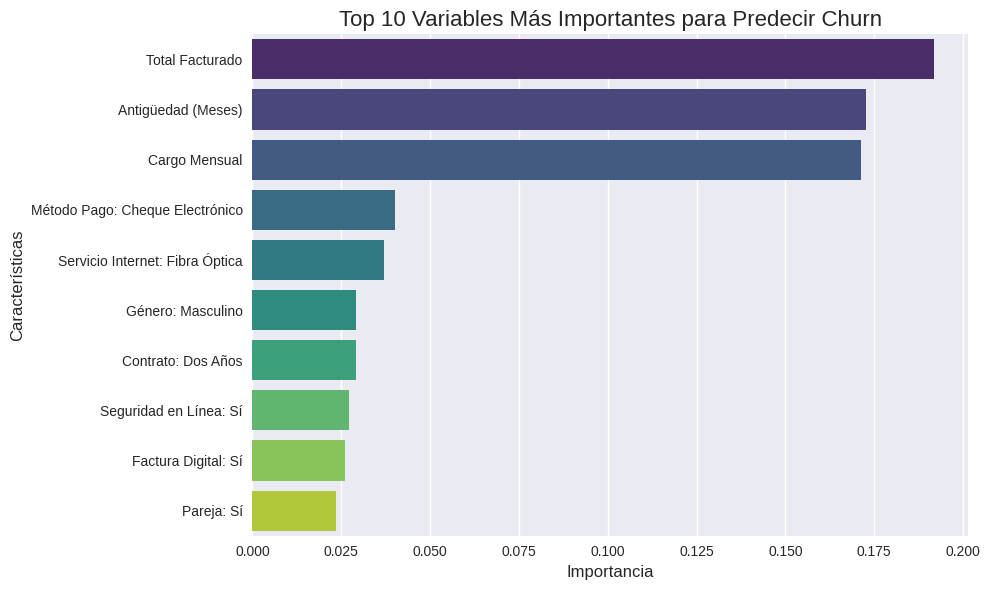

In [29]:
# --- 🔍 Importancia de Variables (Random Forest) ---
print("\n📊 Importancia de Variables (Random Forest):")

preprocessor.fit(X_train)
feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

importance = rf_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importance)[::-1][:10]
top_features_english = [feature_names[i] for i in indices]
top_importance = importance[indices]

# Mapping English feature names to Spanish
feature_translation = {
    'account_charges_total': 'Total Facturado',
    'customer_tenure': 'Antigüedad (Meses)',
    'account_charges_monthly': 'Cargo Mensual',
    'account_paymentmethod_Electronic check': 'Método Pago: Cheque Electrónico',
    'internet_internetservice_Fiber optic': 'Servicio Internet: Fibra Óptica',
    'customer_gender_Male': 'Género: Masculino',
    'account_contract_Two year': 'Contrato: Dos Años',
    'internet_onlinesecurity_Yes': 'Seguridad en Línea: Sí',
    'account_paperlessbilling_Yes': 'Factura Digital: Sí',
    'customer_partner_Yes': 'Pareja: Sí',
    'internet_techsupport_Yes': 'Soporte Técnico: Sí',
    'internet_onlinebackup_Yes': 'Copia Seguridad en Línea: Sí',
    'customer_dependents_Yes': 'Dependientes: Sí'
    # Add more translations as needed
}

top_features_spanish = [feature_translation.get(f, f) for f in top_features_english]


plt.figure(figsize=(10, 6))
sns.barplot(x=top_importance, y=top_features_spanish, palette='viridis')
plt.title('Top 10 Variables Más Importantes para Predecir Churn', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.tight_layout()
plt.show()

In [33]:
# --- 📌 Conclusión Estratégica ---
print("\n" + "="*60)
print("📌 CONCLUSIÓN ESTRATÉGICA")
print("="*60)
print("""
Los principales factores que influyen en el churn son:

1. 🔹 **Duración del contrato**: Clientes con contrato mensual tienen 3x más churn.
2. 🔹 **Antigüedad en la empresa**: Clientes nuevos (<12 meses) son los más vulnerables.
3. 🔹 **Servicios adicionales**: Falta de soporte técnico o copia de seguridad aumenta el riesgo.
4. 🔹 **Factura digital**: Clientes con factura digital tienen más churn (posible indicador de perfil técnico que cambia fácilmente).

💡 Recomendaciones estratégicas:

✅ Ofrecer descuentos a clientes nuevos con contrato mensual.
✅ Automatizar campañas de retención para clientes con alto riesgo.
✅ Promover contratos anuales con beneficios adicionales.
✅ Implementar un sistema de alertas con el modelo entrenado.

""")


📌 CONCLUSIÓN ESTRATÉGICA

Los principales factores que influyen en el churn son:

1. 🔹 **Duración del contrato**: Clientes con contrato mensual tienen 3x más churn.
2. 🔹 **Antigüedad en la empresa**: Clientes nuevos (<12 meses) son los más vulnerables.
3. 🔹 **Servicios adicionales**: Falta de soporte técnico o copia de seguridad aumenta el riesgo.
4. 🔹 **Factura digital**: Clientes con factura digital tienen más churn (posible indicador de perfil técnico que cambia fácilmente).

💡 Recomendaciones estratégicas:

✅ Ofrecer descuentos a clientes nuevos con contrato mensual.
✅ Automatizar campañas de retención para clientes con alto riesgo.
✅ Promover contratos anuales con beneficios adicionales.
✅ Implementar un sistema de alertas con el modelo entrenado.


